#TODO
* remove very uncommon (<10) words

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from collections import Counter, defaultdict
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from nltk.corpus import stopwords

# nltk.download('wordnet')

In [2]:
austen = nltk.corpus.gutenberg.words('austen-sense.txt')

In [3]:
def heatmap_by_topic_doc(z_m_n, K, D):
## Generate a heatmap where x-axis is Document, y-axis is Topic, and value is frequency of assigned words
    distn = np.zeros((D, K))
    for i in range(len(z_m_n)):
        cnt = Counter()
        for j in range(len(z_m_n[i])):
            cnt[z_m_n[i][j]] += 1

        doc_len = len(z_m_n[i])
        for k in range(K):
            distn[i,k] = cnt.get(k,0) / doc_len

    sns.heatmap(distn.T,cmap='Greys', vmin=0, vmax=1)
    plt.xlabel('Document')
    plt.ylabel('Topic')
    plt.show()

# Using Jane Austen's **Sense**
## [1] Preprocessing
* Remove all non-words
* Remove all stop words
* Lowercase and lemmatize

In [4]:
austen = ' '.join(austen)
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
austen = tokenizer.tokenize(austen) # remove nonwords

# nltk.download('stopwords')

austen = [word.lower() for word in austen]
austen = [word for word in austen if not word in stopwords.words('english')] # remove stop words
austen = [lemmatizer.lemmatize(word) for word in austen]

austen_list = austen
austen_str = ' '.join(austen)

### [1.1] Word-to-Int mapping

In [5]:
freqs = Counter()
tokens = austen_str.lower().split()
for token in tokens:
    freqs[token] += 1                                 # freqs is dict(), i.e. freqs[word] = count
freqs = freqs.most_common()                   # now freqs is tuple of (word, count)
word2int = {freqs[i][0]:i+1 for i in range(len(freqs))}  # mapping is dict of freqs[word]=r where r=rank
int2word = {v:k for k,v in word2int.items()}

### [1.2] Split the corpus into documents on the word "chapter"

In [6]:
docs = []
start = 0
i = 0
while i < len(austen_list):
    if austen_list[i] == 'chapter':
        docs.append(austen_list[start:i-1])
        start = i + 1
    i += 1
    
docs = docs[1:]
N_W = sum(len(doc) for doc in docs)
N_W_unique = len(set(austen_list))
N_D = len(docs)
print('Total number of tokens: ' + str(N_W))
print('Number of unique tokens: ' + str(N_W_unique))
print('Number of documents: ' + str(N_D))

Total number of tokens: 52750
Number of unique tokens: 5692
Number of documents: 49


### [1.3] Collapsed Gibbs Sampling

In [7]:
K = 10
V = len(set(austen_list))
D = len(docs)
alpha = 0.1
beta = alpha

# for printing a number of words from randomly chosen topics (to compare before and after)
topic_groups_to_print = np.random.randint(0, K, 2)
number_words_to_print = 10

#### [1.31] Initialization

Initialized heatmap


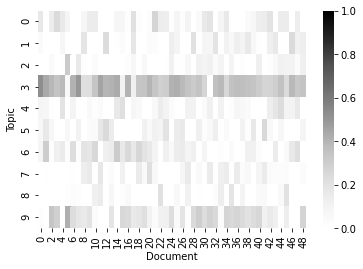

Most common words from topic group #8
woman,voice,card,carriage,something,engagement,dashwood,evening,little,middleton,

Most common words from topic group #3
marianne,one,must,every,said,would,mr,could,elinor,sister,



In [8]:
z_d_ld = [] # word-topic assignment (size = # documents x len(document i)), topic<-z
n_d_k = np.zeros((D, K)) + alpha # word counts by document and topic
n_k_v = np.zeros((K, V)) + beta # word counts by topic and word2int
n_k = np.zeros(K) + V*beta # word counts by topic
for i_doc, doc in enumerate(docs):
    z_n = []
    for word in doc:
        p_z = n_k_v[:, word2int[word]] * n_d_k[i_doc] / n_k     # probability dist'n of topics
        z = np.random.multinomial(1, p_z / p_z.sum()).argmax()  # randomly sampled topic
        
        # increment this topic
        z_n.append(z)
        n_d_k[i_doc, z] += 1
        n_k_v[z, word2int[word]] += 1
        n_k[z] += 1
    z_d_ld.append(np.array(z_n))
    
print('Initialized heatmap')
heatmap_by_topic_doc(z_d_ld, K, D)

for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = np.argpartition(n_k_v[group_id, :], -number_words_to_print)[-number_words_to_print:]
    for idd in ids:
        print(int2word[idd],end=',')
    print('\n')

#### [1.32] Iteration

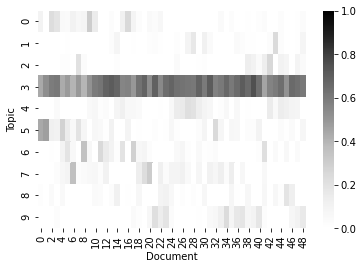

Most common words from topic group #8
latter,invitation,sigh,eye,behaviour,attachment,margaret,plan,liberty,suffered,

Most common words from topic group #3
time,must,one,every,said,would,sister,could,elinor,mr,



In [11]:
num_iter = 250
for i in range(num_iter):
    for i_doc, doc in enumerate(docs):
        for i_word, word in enumerate(doc):
            z = z_d_ld[i_doc][i_word]
            # decrement this topic
            n_d_k[i_doc, z] -= 1
            n_k_v[z, word2int[word]] -= 1
            n_k[z] -= 1
            
            # draw new topic
            p_z = n_d_k[i_doc] * n_k_v[:, word2int[word]] / n_k
            new_z = np.random.multinomial(1, p_z / p_z.sum()).argmax()
            
            # increment new topic
            z_d_ld[i_doc][i_word] = new_z
            n_d_k[i_doc, new_z] += 1
            n_k_v[new_z, word2int[word]] += 1
            n_k[new_z] += 1
    print('Iteration #', i)
    clear_output(wait=True)
    
heatmap_by_topic_doc(z_d_ld, K, D)
for group_id in topic_groups_to_print:
    print('Most common words from topic group #' + str(group_id))
    ids = np.argpartition(n_k_v[group_id, :], -number_words_to_print)[-number_words_to_print:]
    for idd in ids:
        print(int2word[idd],end=',')
    print('\n')

### [2] Hidden Markov Topic Model